# Import Library

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.combine import SMOTETomek
from collections import Counter

# Data Understanding

In [2]:
# load data
df = pd.read_csv('diabetes_prediction_dataset.csv')
print("=== Info Data ===")
df.info()

=== Info Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Dataset ini memiliki 100.000 entri dan 9 kolom dengan informasi pasien terkait risiko diabetes. Berikut ringkasan struktur datanya:

Fitur dalam dataset:
gender: Jenis kelamin (Female/Male)

age: Usia pasien

hypertension: Riwayat hipertensi (0 = tidak, 1 = ya)

heart_disease: Riwayat penyakit jantung (0 = tidak, 1 = ya)

smoking_history: Riwayat merokok

bmi: Body Mass Index

HbA1c_level: Level HbA1c

blood_glucose_level: Kadar gula darah

diabetes: Label target (0 = tidak diabetes, 1 = diabetes)

In [10]:
print("\n=== Statistika Deskriptif ===")
df.describe()


=== Statistika Deskriptif ===


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [11]:
# Cek missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Missing Values ===
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [12]:
# Cek duplicate
print("\n=== Duplicate Values ===")
print(df.duplicated().sum())


=== Duplicate Values ===
3854


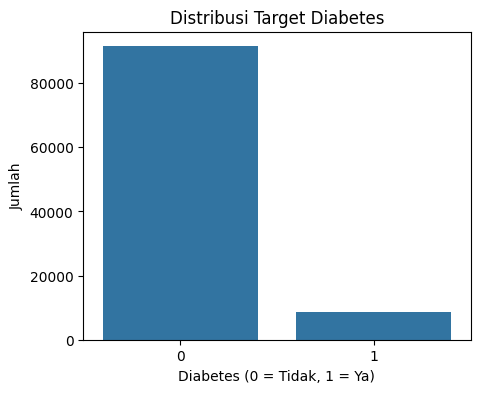

In [13]:
# Cek distribusi target
plt.figure(figsize=(5,4))
sns.countplot(x='diabetes', data=df)
plt.title('Distribusi Target Diabetes')
plt.xlabel('Diabetes (0 = Tidak, 1 = Ya)')
plt.ylabel('Jumlah')
plt.show()

Distribusi target diabetes sangat tidak seimbang, dengan mayoritas individu dikategorikan sebagai non-diabetes (0) dan hanya sebagian kecil yang didiagnosis diabetes (1).

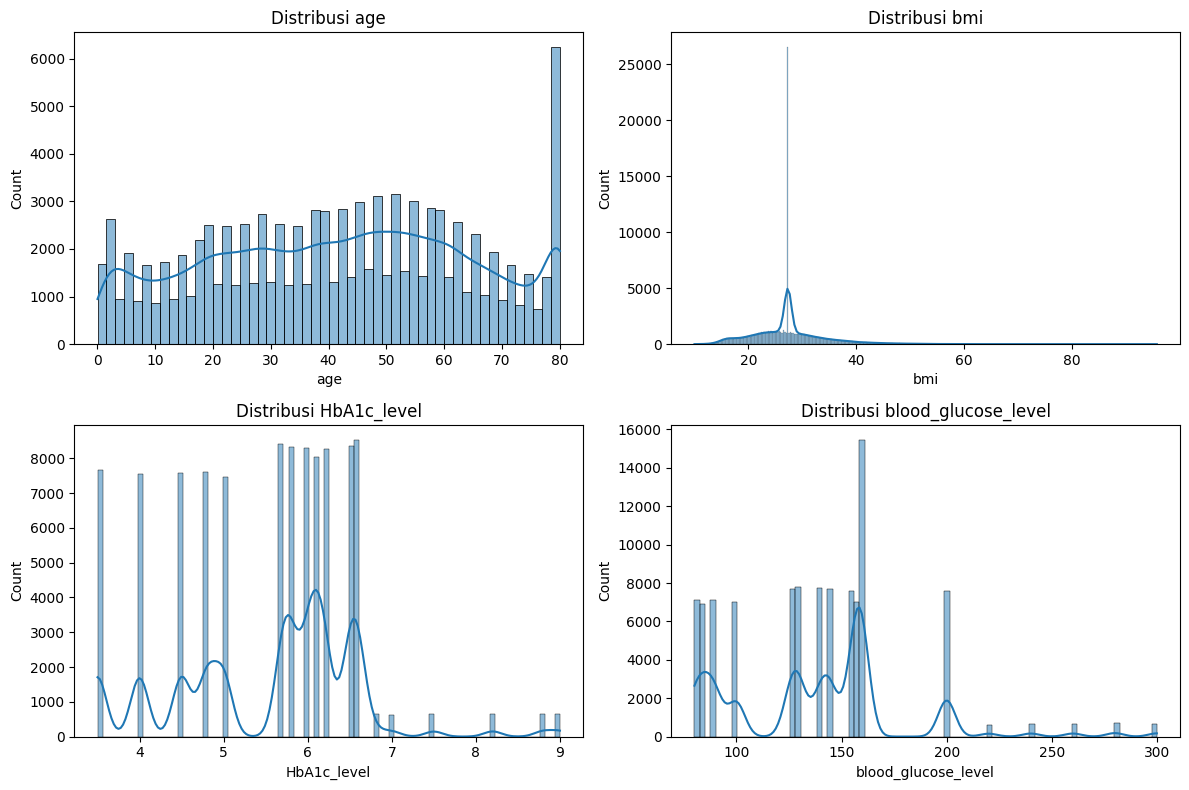

In [3]:
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Buat satu figure dengan 2 baris x 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Ubah jadi 1D array biar gampang di-loop

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribusi {col}')

plt.tight_layout()
plt.show()


Distribusi kadar glukosa, misalnya, menunjukkan penyebaran yang luas dengan puncak frekuensi yang berada pada rentang antara 90 hingga 150 mg/dL. Hal ini mengindikasikan bahwa sebagian besar individu dalam populasi cenderung memiliki kadar glukosa dalam kisaran normoglikemia hingga ambang hiperglikemia. Variabel indeks massa tubuh (BMI) memperlihatkan kecenderungan distribusi yang miring ke kanan, dengan mayoritas individu berada pada rentang 25–35 kg/m², yang menunjukkan bahwa populasi memiliki dominasi berat badan berlebih hingga obesitas. Usia memiliki distribusi unimodal dengan penyebaran dari usia muda hingga lanjut, dan konsentrasi frekuensi berada di sekitar rentang 40–60 tahun. Tekanan darah juga menunjukkan distribusi normal yang agak menyebar, dengan nilai yang banyak muncul pada kisaran 70–85 mmHg (diasumsikan sebagai tekanan diastolik atau rerata tekanan darah).

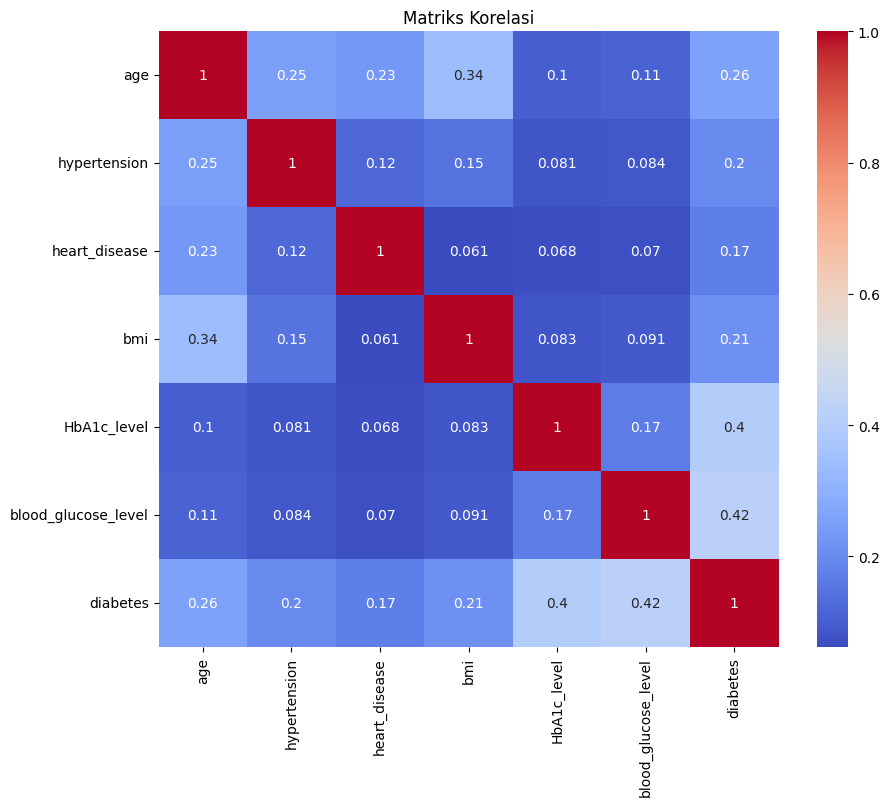

In [19]:
# Korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()

variabel HbA1c dan glukosa darah menunjukkan korelasi tertinggi terhadap status diabetes, masing-masing sekitar +0,42 dan +0,4, menjadikannya indikator klinis utama dalam prediksi diabetes. Indeks massa tubuh (BMI) memiliki korelasi sedang, sekitar +0,21, diikuti oleh hipertensi dan usia, masing-masing sekitar +0,2 dan +0,26. Korelasi dengan penyakit jantung rendah, sekitar 0,17.

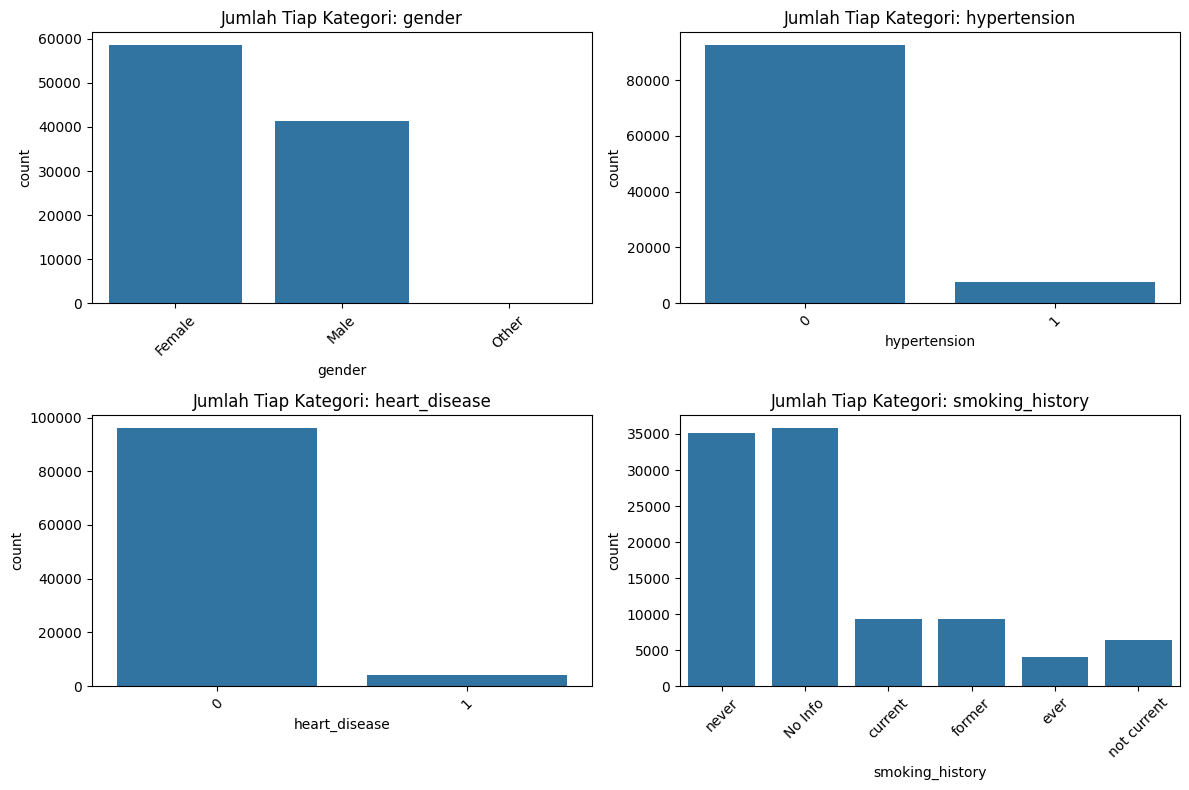

In [4]:
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

# Buat figure dengan 2 baris x 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Jumlah Tiap Kategori: {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Pada fitur jenis kelamin (gender), distribusi terbagi ke dalam tiga kategori: Female, Male, dan Other. Mayoritas responden adalah Female dan Male, dengan jumlah relatif seimbang, sementara kategori Other memiliki proporsi yang sangat kecil, mencerminkan keberadaan individu non-biner atau data yang tidak diklasifikasikan secara tradisional. Fitur riwayat merokok (smoking_history) memiliki enam kategori: never, no info, current, former, ever, dan not current. Kategori never mendominasi distribusi, menunjukkan sebagian besar responden tidak pernah merokok. Diikuti oleh kategori former dan ever, yang menunjukkan riwayat merokok di masa lalu, serta current, yang mewakili perokok aktif. not current tampaknya digunakan untuk mengklasifikasikan individu yang saat ini tidak merokok, meskipun pernah, sementara no info menunjukkan data tidak tersedia atau tidak dijawab. Keberadaan kategori seperti no info penting untuk dicermati karena dapat merepresentasikan ketidaklengkapan data. Fitur hipertensi (hypertension) hanya memiliki dua kategori: yes dan no, dengan mayoritas responden tidak memiliki riwayat hipertensi (no). Sementara itu, fitur penyakit jantung (heart_disease) juga terdiri dari dua kategori: yes dan no, dan secara umum menunjukkan proporsi yang lebih besar pada kategori no, mengindikasikan bahwa sebagian besar individu dalam populasi ini tidak memiliki riwayat penyakit jantung.

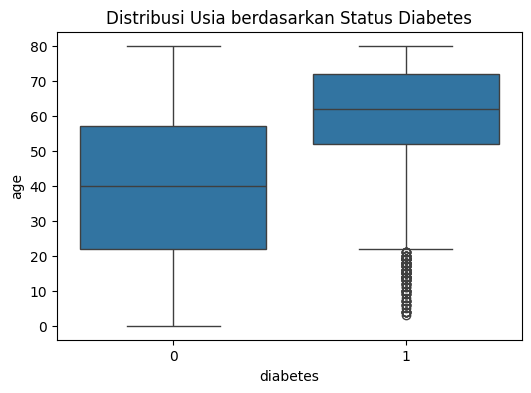

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x='diabetes', y='age', data=df)
plt.title("Distribusi Usia berdasarkan Status Diabetes")
plt.show()

Tampak bahwa prevalensi diabetes meningkat secara progresif seiring bertambahnya usia.

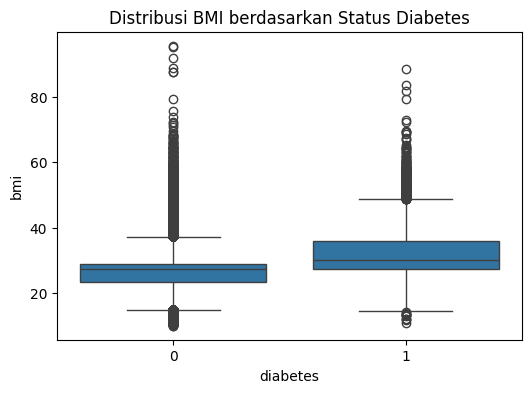

In [22]:
plt.figure(figsize=(6,4))
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title("Distribusi BMI berdasarkan Status Diabetes")
plt.show()

Terlihat bahwa individu dengan nilai BMI tinggi memiliki kecenderungan lebih besar untuk menderita diabetes.

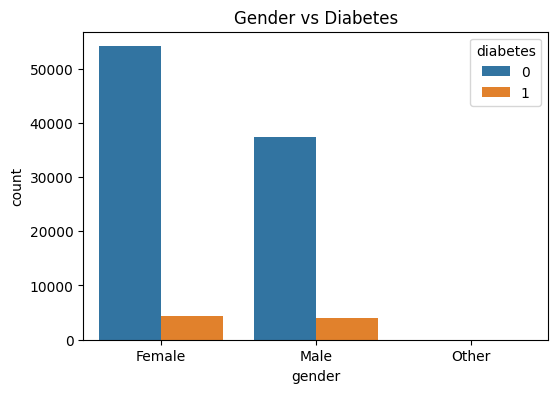

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title("Gender vs Diabetes")
plt.show()

Tidak terlihat perbedaan yang mencolok antara laki-laki dan perempuan dalam hal prevalensi diabetes. Ini menunjukkan bahwa jenis kelamin mungkin bukan faktor determinan utama dalam model prediksi diabetes pada dataset ini.

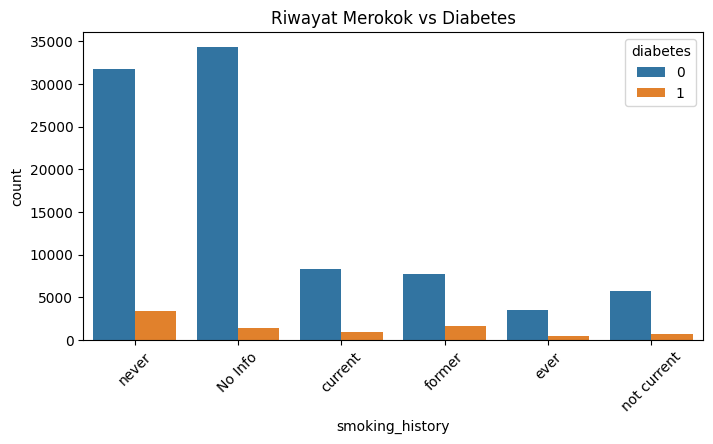

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(x='smoking_history', hue='diabetes', data=df)
plt.title("Riwayat Merokok vs Diabetes")
plt.xticks(rotation=45)
plt.show()

Proporsi individu dengan diabetes lebih tinggi pada kelompok perokok aktif dibandingkan dengan bukan perokok. Hal ini mengindikasikan adanya potensi asosiasi positif antara kebiasaan merokok dan kejadian diabetes.

# Data Preparation


In [5]:
# Hapus duplikat
df.drop_duplicates(inplace=True)

In [6]:
# Hapus gender 'Other'
df = df[df['gender'].isin(['Male', 'Female'])]

# Hapus baris dengan nilai 'No Info' di kolom smoking_history
df = df[df['smoking_history'] != 'No Info']

In [8]:
# Encode variabel kategorikal
df_encoded = df.copy()
le_gender = LabelEncoder()
le_smoking = LabelEncoder()
df_encoded['gender'] = le_gender.fit_transform(df_encoded['gender'])
df_encoded['smoking_history'] = le_smoking.fit_transform(df_encoded['smoking_history'])

In [9]:
# Pisahkan fitur dan target
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Standardisasi fitur numerik
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Balancing
sm = SMOTETomek(random_state=0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

print("\nDistribusi kelas sebelum SMOTETomek:", Counter(y_train))
print("Distribusi kelas sesudah SMOTETomek:", Counter(y_train_resampled))


Distribusi kelas sebelum SMOTETomek: Counter({0: 44892, 1: 5705})
Distribusi kelas sesudah SMOTETomek: Counter({0: 44414, 1: 44414})


# Modelling dan Tunning

In [29]:
results = []

# Random Forest
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test_scaled)
results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'Best Params': rf.best_params_
})

In [30]:
# XGBoost
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3]
}
xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, cv=3, n_jobs=-1)
xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test_scaled)
results.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'Best Params': xgb.best_params_
})

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:43:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [31]:
# Logistic Regression
lr_params = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear']
}
lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), lr_params, cv=3, n_jobs=-1)
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_test_scaled)
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'Best Params': lr.best_params_
})

# Evaluation

In [32]:
results_df = pd.DataFrame(results)
print("\n=== Hasil Evaluasi Model ===")
results_df


=== Hasil Evaluasi Model ===


,Model,Accuracy,Precision,Recall,F1 Score,Best Params
0,Random Forest,0.949170,0.766023,0.744745,0.755234,"{'max_depth': None, 'min_samples_split': 2, 'n..."
1,XGBoost,0.960000,0.889623,0.707958,0.788462,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti..."
2,Logistic Regression,0.875968,0.453144,0.860360,0.593629,"{'C': 0.1, 'solver': 'liblinear'}"


Dari tabel di atas, dapat disimpulkan bahwa XGBoost merupakan model dengan performa terbaik karena memberikan nilai F1 score tertinggi (0.7885), yang menandakan keseimbangan yang baik antara precision dan recall. Model ini juga memiliki precision tertinggi (0.8896), yang berarti model sangat jarang melakukan false positive, serta tetap mampu menjaga recall yang cukup baik Logistic Regression memiliki recall yang tinggi, namun precision-nya sangat rendah sehingga kurang ideal untuk digunakan sebagai model utama. Sementara Random Forest memberikan hasil yang seimbang, namun masih berada di bawah XGBoost dalam semua metrik utama.

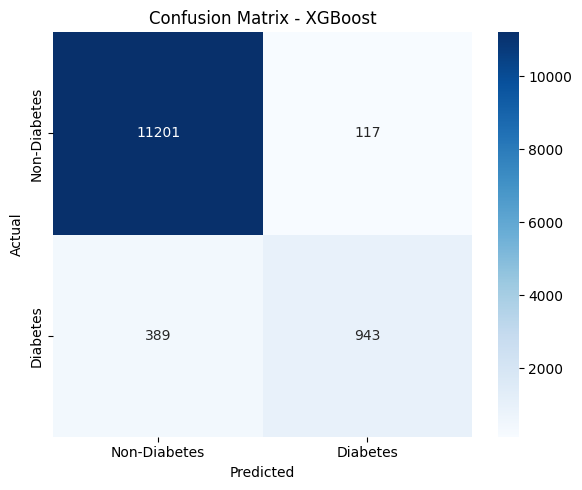

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi dari model terbaik
y_pred_xgb = xgb.best_estimator_.predict(X_test_scaled)

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Label kelas: asumsi 0 = Non-Diabetes, 1 = Diabetes
labels = ['Non-Diabetes', 'Diabetes']

# Visualisasi pakai seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()


Model XGBoost menunjukkan performa yang tinggi secara keseluruhan dengan akurasi sebesar 96%, didominasi oleh kemampuan mengenali individu non-diabetes (true negative). Namun, model masih menghasilkan 389 false negative, yang berarti sekitar 29% dari kasus diabetes tidak terdeteksi. Meskipun precision model tinggi (88,96%)—menunjukkan bahwa sebagian besar prediksi positif benar adanya—nilai recall sebesar 70,81% menunjukkan bahwa sensitivitas terhadap penderita diabetes masih dapat ditingkatkan. Dengan F1-score sebesar 78,72%, model menunjukkan keseimbangan yang cukup baik antara presisi dan sensitivitas, namun tetap perlu perhatian terhadap under-detection pada kelas minoritas (diabetes).



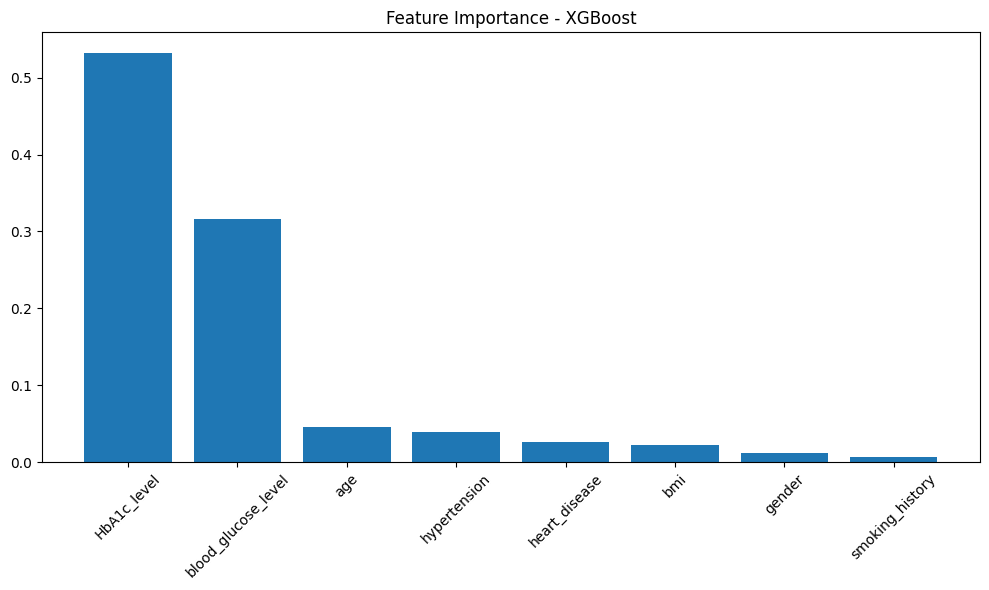

In [35]:
# Ambil model terbaik dari GridSearch
xgb_best = xgb.best_estimator_

# Ambil nama fitur dari data training
feature_names = X_train.columns

# Ambil importance dan urutkan
importances = xgb_best.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - XGBoost")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

Hasil feature importance dari model XGBoost menunjukkan bahwa HbA1c level merupakan prediktor paling dominan dengan skor penting sekitar 0,53, diikuti oleh blood glucose level sebesar 0,32. Kedua variabel ini merupakan indikator klinis utama dalam diagnosis diabetes, sehingga konsistensi ini memperkuat validitas model. Fitur-fitur lain seperti age, hypertension, dan heart_disease menunjukkan kontribusi yang jauh lebih kecil (masing-masing <0,05), menandakan bahwa meskipun relevan secara klinis, pengaruhnya dalam model prediktif lebih rendah. BMI, gender, dan smoking_history memiliki nilai penting yang sangat rendah (<0,03), menunjukkan peran minimal dalam klasifikasi oleh model ini.

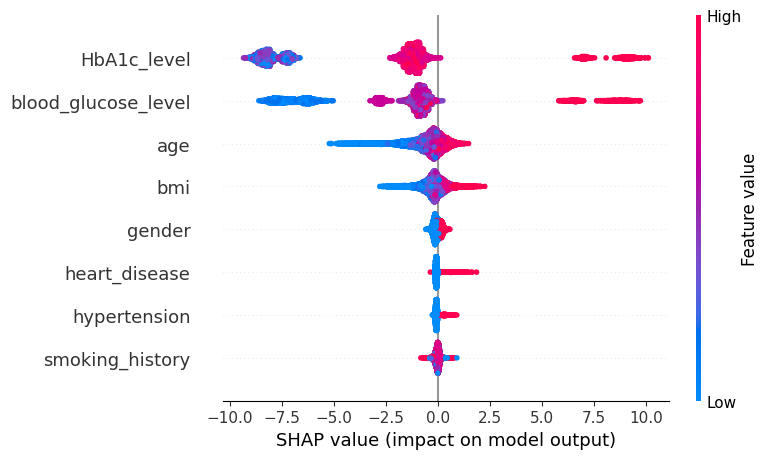

In [36]:
import shap

# Buat explainer khusus XGBoost
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test_scaled)

# Summary plot (global interpretasi)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)


Visualisasi SHAP memperlihatkan dampak setiap fitur terhadap output prediksi secara individual dan global. HbA1c level dan blood glucose level tidak hanya dominan dalam feature importance, tetapi juga memiliki SHAP value yang tinggi dan terdistribusi luas, baik ke arah positif maupun negatif, menunjukkan bahwa nilai tinggi dari kedua fitur ini secara konsisten mendorong prediksi ke arah diabetes. Fitur age dan BMI juga berkontribusi secara signifikan, dengan nilai tinggi mendorong prediksi positif terhadap diabetes, meskipun dengan magnitudo yang lebih rendah dibanding HbA1c. Sementara itu, fitur seperti gender, heart_disease, hypertension, dan smoking_history menunjukkan distribusi SHAP yang lebih sempit dan kecil, mencerminkan dampak yang terbatas terhadap model.